# **Experiment_1**

In [1]:
import numpy as np 
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
image_path= '/content/gdrive/MyDrive/soft computing /assignment_2/Dataset/training-a'


In [4]:
cls_data = pd.read_csv('/content/gdrive/MyDrive/soft computing /assignment_2/Dataset/training-a.csv')
cls_data.head()
cls_data.columns
cls_data = cls_data.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
new_data=cls_data
new_data

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [6]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(210),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(210),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(new_data, image_path, train_transform)
test_data = Dataset(new_data, image_path, test_transform)

print("Trainig Samples: ",len(train_data))


Trainig Samples:  19702


In [7]:
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(train_data, test_size = 0.2)
print(len(train_dataset))
print(len(test_dataset))

15761
3941


In [8]:
batch_size = 20
num_iters = 20000
input_dim = 210*210 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [10]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()

        self.linear_6= nn.Linear(num_hidden, num_hidden)
        
        self.relu_6= nn.ReLU()

        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.295457601547241. Accuracy: 9.540725704136007
Iteration: 1000. Loss: 2.3025565147399902. Accuracy: 9.845216950012688
Iteration: 1500. Loss: 2.3054099082946777. Accuracy: 9.972088302461303
Iteration: 2000. Loss: 2.3008360862731934. Accuracy: 9.109363105810708
Iteration: 2500. Loss: 2.3009841442108154. Accuracy: 14.742451154529308
Iteration: 3000. Loss: 2.298485279083252. Accuracy: 10.733316417153008
Iteration: 3500. Loss: 2.31040096282959. Accuracy: 11.621415884293327
Iteration: 4000. Loss: 2.2527778148651123. Accuracy: 14.514082720121797
Iteration: 4500. Loss: 2.2454991340637207. Accuracy: 15.097690941385435
Iteration: 5000. Loss: 2.3149313926696777. Accuracy: 17.330626744481098
Iteration: 5500. Loss: 2.8098716735839844. Accuracy: 10.276579548337985
Iteration: 6000. Loss: 2.1808695793151855. Accuracy: 18.675463080436437
Iteration: 6500. Loss: 2.0945029258728027. Accuracy: 19.487439736107586
Iteration: 7000. Loss: 2.031571865081787. Accuracy: 19.639685359045927
It

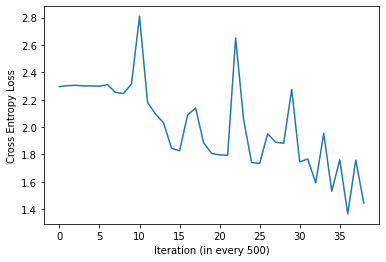

In [12]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Experiment_2.1**

In [13]:
batch_size = 50
num_iters = 30000
input_dim = 210*210 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [14]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
         
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        
        self.relu_5= nn.ReLU()

        self.linear_6= nn.Linear(num_hidden, num_hidden)
        
        self.relu_6= nn.ReLU()

        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.298093318939209. Accuracy: 9.972088302461303
Iteration: 1000. Loss: 2.2989914417266846. Accuracy: 11.49454453184471
Iteration: 1500. Loss: 2.3025426864624023. Accuracy: 9.845216950012688
Iteration: 2000. Loss: 2.3008830547332764. Accuracy: 9.48997716315656
Iteration: 2500. Loss: 2.301804542541504. Accuracy: 12.509515351433647
Iteration: 3000. Loss: 2.2960164546966553. Accuracy: 12.38264399898503
Iteration: 3500. Loss: 2.280031681060791. Accuracy: 14.488708449632073
Iteration: 4000. Loss: 2.2176692485809326. Accuracy: 17.43212382643999
Iteration: 4500. Loss: 2.115494728088379. Accuracy: 14.691702613549861
Iteration: 5000. Loss: 2.1372382640838623. Accuracy: 18.82770870337478
Iteration: 5500. Loss: 2.099846124649048. Accuracy: 20.629281908145142
Iteration: 6000. Loss: 2.0001511573791504. Accuracy: 19.030702867292565
Iteration: 6500. Loss: 1.8178825378417969. Accuracy: 21.720375539203246
Iteration: 7000. Loss: 2.134942054748535. Accuracy: 23.344328850545548
Iterati

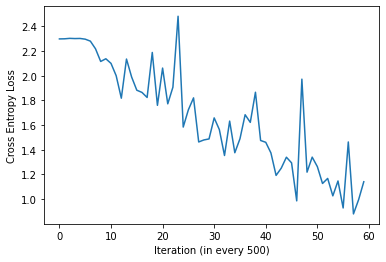

In [15]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Experiment_2.2**

In [16]:
batch_size = 50
num_iters = 30000
input_dim = 210*210 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [17]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2978086471557617. Accuracy: 10.175082466379092
Iteration: 1000. Loss: 2.2698400020599365. Accuracy: 14.46333417914235
Iteration: 1500. Loss: 2.284916639328003. Accuracy: 12.712509515351433
Iteration: 2000. Loss: 2.1599879264831543. Accuracy: 20.680030449124587
Iteration: 2500. Loss: 2.1430017948150635. Accuracy: 25.98325298147678
Iteration: 3000. Loss: 2.0793304443359375. Accuracy: 18.19335194113169
Iteration: 3500. Loss: 2.304304838180542. Accuracy: 15.452930728241563
Iteration: 4000. Loss: 1.8370896577835083. Accuracy: 21.238264399898505
Iteration: 4500. Loss: 2.092411756515503. Accuracy: 26.363867038822633
Iteration: 5000. Loss: 1.793751835823059. Accuracy: 26.99822380106572
Iteration: 5500. Loss: 2.0157313346862793. Accuracy: 28.343060137021062
Iteration: 6000. Loss: 1.8143075704574585. Accuracy: 36.843440751078404
Iteration: 6500. Loss: 1.6651980876922607. Accuracy: 30.220756153260595
Iteration: 7000. Loss: 1.5138561725616455. Accuracy: 34.153768079167726
I

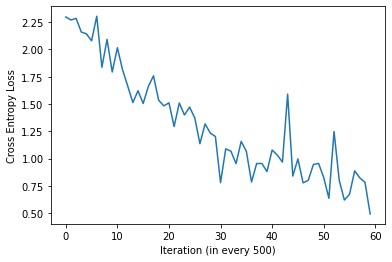

In [18]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# **Experiment_2.3**

In [19]:
batch_size = 150
num_iters = 40000
input_dim = 210*210 
num_hidden = 200  
output_dim = 10
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)   

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [20]:
import torch.nn as nn
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        
        self.relu_1 = nn.ReLU()
 
        
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_2 = nn.ReLU()
 
        
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_3 = nn.ReLU()
 
         
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        
        self.relu_4 = nn.ReLU()
 
        
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas
 
# INSTANTIATE MODEL CLASS
 
model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)
 
# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
 
iter_loss = [] 
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
 
        images = images.view(-1, 210*210).to(device)
        labels = labels.to(device)
 
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
 
        # Forward pass to get output/logits
        outputs = model(images) 
 
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
 
        # Getting gradients w.r.t. parameters
        loss.backward()
 
        # Updating parameters
        optimizer.step()
 
        iter += 1
 
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 210*210).to(device)
 
                # Forward pass only to get logits/output
                outputs = model(images)
 
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)
 
                # Total number of labels
                total += labels.size(0)
 
 
                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()
 
            accuracy = 100 * correct.item() / total
 
            # Print Loss
            iter_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2968192100524902. Accuracy: 11.190053285968029
Iteration: 1000. Loss: 2.2349917888641357. Accuracy: 18.345597564070033
Iteration: 1500. Loss: 2.1074304580688477. Accuracy: 20.451662014717076
Iteration: 2000. Loss: 2.037034511566162. Accuracy: 25.856381629028167
Iteration: 2500. Loss: 2.226857900619507. Accuracy: 19.994925145902055
Iteration: 3000. Loss: 2.0633766651153564. Accuracy: 31.768586653133724
Iteration: 3500. Loss: 2.121579647064209. Accuracy: 30.880487185993402
Iteration: 4000. Loss: 1.9612268209457397. Accuracy: 27.048972342045165
Iteration: 4500. Loss: 1.5911098718643188. Accuracy: 38.08678000507486
Iteration: 5000. Loss: 1.7400569915771484. Accuracy: 34.17914234965745
Iteration: 5500. Loss: 1.6561490297317505. Accuracy: 29.6878964729764
Iteration: 6000. Loss: 1.941624402999878. Accuracy: 27.860948997716317
Iteration: 6500. Loss: 1.6588072776794434. Accuracy: 37.85841157066734
Iteration: 7000. Loss: 1.5180453062057495. Accuracy: 40.97944684090332
Ite

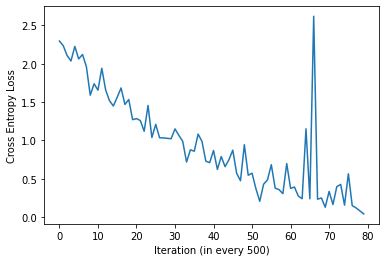

In [21]:
plt.plot(iter_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()